<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#IMPORT-PACKAGES" data-toc-modified-id="IMPORT-PACKAGES-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>IMPORT PACKAGES</a></span><ul class="toc-item"><li><span><a href="#Import-customize-functions-for-fitting-data" data-toc-modified-id="Import-customize-functions-for-fitting-data-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Import customize functions for fitting data</a></span></li></ul></li><li><span><a href="#LOAD-DATA" data-toc-modified-id="LOAD-DATA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>LOAD DATA</a></span></li><li><span><a href="#DATA-VISUALISATION" data-toc-modified-id="DATA-VISUALISATION-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>DATA VISUALISATION</a></span><ul class="toc-item"><li><span><a href="#Amplification-curve-visualisation" data-toc-modified-id="Amplification-curve-visualisation-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Amplification curve visualisation</a></span></li><li><span><a href="#Melting-curve-visualisation" data-toc-modified-id="Melting-curve-visualisation-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Melting curve visualisation</a></span></li><li><span><a href="#Melting-peaks-distribution" data-toc-modified-id="Melting-peaks-distribution-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Melting peaks distribution</a></span></li><li><span><a href="#Digital-Standard-Curves" data-toc-modified-id="Digital-Standard-Curves-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Digital Standard Curves</a></span></li></ul></li><li><span><a href="#MACHINE-LEARNING-ALGORITHM" data-toc-modified-id="MACHINE-LEARNING-ALGORITHM-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>MACHINE LEARNING ALGORITHM</a></span><ul class="toc-item"><li><span><a href="#Encoding-labels-and-select-dataset" data-toc-modified-id="Encoding-labels-and-select-dataset-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Encoding labels and select dataset</a></span></li><li><span><a href="#Logistic-Regression-and-k-NN" data-toc-modified-id="Logistic-Regression-and-k-NN-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Logistic Regression and k-NN</a></span></li><li><span><a href="#Confusion-Matrix-classification-at-WELL-LEVEL" data-toc-modified-id="Confusion-Matrix-classification-at-WELL-LEVEL-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Confusion Matrix classification at WELL LEVEL</a></span></li><li><span><a href="#Checking-panel-Results-(sample-level)" data-toc-modified-id="Checking-panel-Results-(sample-level)-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Checking panel Results (sample level)</a></span></li><li><span><a href="#Confusion-Matrix-classification-at-SAMPLE-LEVEL" data-toc-modified-id="Confusion-Matrix-classification-at-SAMPLE-LEVEL-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Confusion Matrix classification at SAMPLE LEVEL</a></span></li></ul></li></ul></div>

# IMPORT PACKAGES

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import time
from datetime import datetime
from pathlib import Path

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

## Import customize functions for fitting data

In [3]:
import functions.fitting_func as fitfunc
import functions.peak_finder as peakfunc
import functions.plotting_func as plotfunc
import functions.machine_learning as mlfunc
import functions.utilities as utils

# This function is avaliabe in the function folder and 
# it is used to set the colour blind friendly palette:
utils.colourblind()

# LOAD DATA

In [4]:
df_AC_bs_filt = pd.read_csv("data/df_AC_bs_pos.gz", compression='gzip', index_col=0, low_memory=False)
df_MC_filt = pd.read_csv("data/df_MC_pos.gz", compression='gzip', index_col=0, low_memory=False)
df_training = pd.read_csv("data/training_dataset.csv", index_col=0, low_memory=False)
df_master = pd.read_csv("data/df_master_dPCR.gz", compression='gzip', index_col=0, low_memory=False)

In [5]:
# as we are using dataframes, the first 6 columns have all the information
# about the samples (or gblocks), concetrations and melting peak values.
NMETA = 5 

# here the Primer Mix (PM) name is specified.
PM = "PM5.3"

# setting column index as integers(after reading csv)
df_MC_filt = utils.order_columns(df_MC_filt, NMETA=NMETA)
df_AC_bs_filt = utils.order_columns(df_AC_bs_filt, NMETA=NMETA)
df_training = utils.order_columns(df_training, NMETA=NMETA+1)
df_master = utils.order_columns(df_master, NMETA=NMETA+1)


# visualising the head of the dataframe
df_master.head()

,Channel,PrimerMix,Target,CPE_type,Conc,MeltPeaks,1.0,2.0,3.0,4.0,...,36.0,37.0,38.0,39.0,40.0,41.0,42.0,43.0,44.0,45.0
0,panel01,PM5.3,NDM,ndm,100000,90.872338,-0.00708,-0.005980,-0.005250,-0.003784,...,0.7840,0.7870,0.7925,0.7980,0.8027,0.8060,0.8110,0.8160,0.8203,0.8230
1,panel01,PM5.3,NDM,ndm,100000,90.815004,-0.00830,-0.006836,-0.005493,-0.003906,...,0.7730,0.7764,0.7817,0.7880,0.7930,0.7954,0.7983,0.8010,0.8047,0.8086
2,panel01,PM5.3,NDM,ndm,100000,90.752269,-0.01196,-0.009400,-0.006836,-0.003662,...,0.7540,0.7550,0.7560,0.7590,0.7617,0.7627,0.7627,0.7637,0.7656,0.7695
3,panel01,PM5.3,NDM,ndm,100000,90.711903,-0.00830,-0.007812,-0.006104,-0.003662,...,0.7676,0.7690,0.7715,0.7744,0.7770,0.7800,0.7827,0.7866,0.7900,0.7925
4,panel01,PM5.3,NDM,ndm,100000,90.788188,-0.00989,-0.009030,-0.007202,-0.004395,...,0.7560,0.7590,0.7617,0.7666,0.7705,0.7734,0.7783,0.7812,0.7840,0.7850


# DATA VISUALISATION
The following visualisation is based on the TRAINING DATASET.

From the whole data set (including gblocks and samples), we specify that the training data set contains samples with defined concentrations. In our case, we know the concentration of gblocks, but leave "UNK" for the samples.

In [6]:
train_plot = df_AC_bs_filt.loc[df_AC_bs_filt.Conc != 'unk']
train_plot.shape

(29165, 50)

## Amplification curve visualisation

The following plot shows a sample of training amplification curves (specifically 200 curves chosen randomly for each target) obtained from a real-time digital PCR instrument and their average curves for each datapoint (or cycle).

  0%|          | 0/5 [00:00<?, ?it/s]

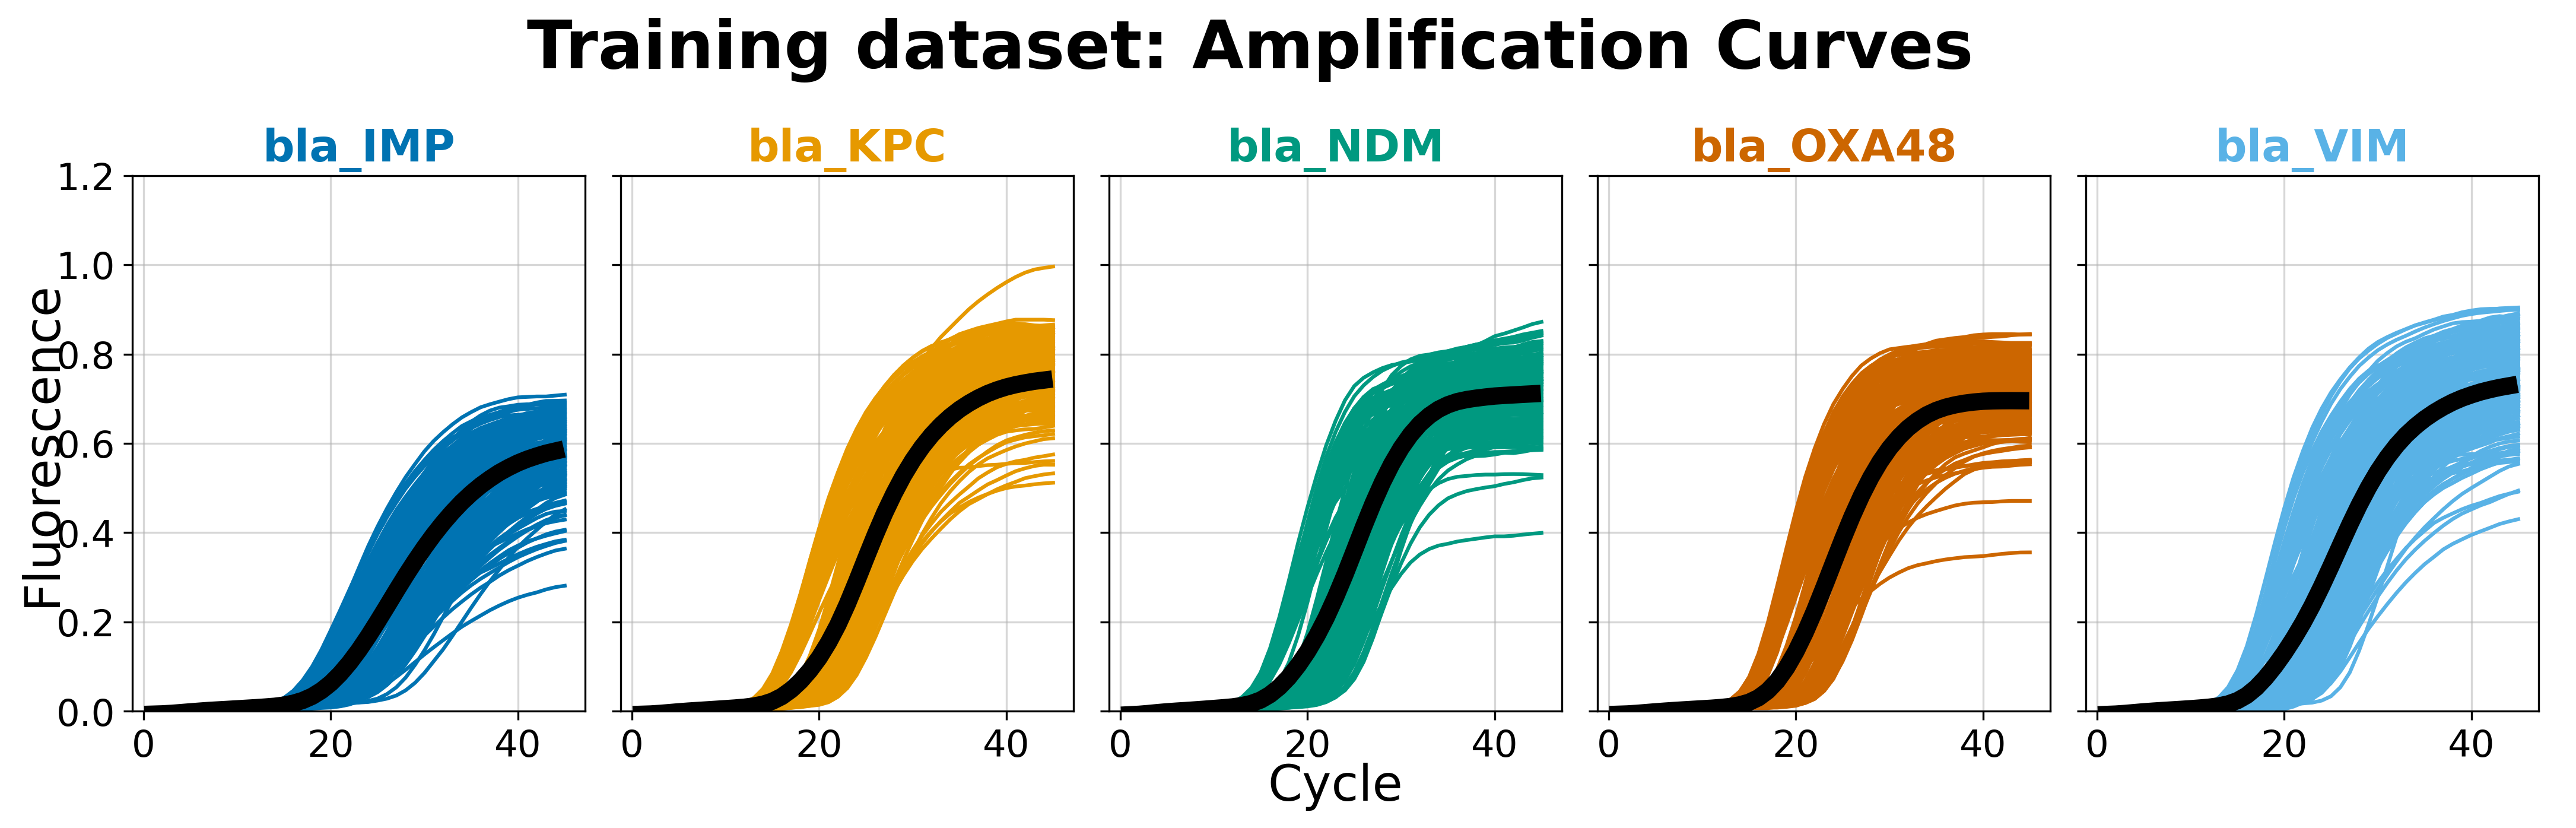

In [7]:
plotfunc.plot_training_amplification_curves(train_plot, NMETA)

## Melting curve visualisation
The following plot shows a sample of training melting curves (specifically 400 curves chosen randomly for each target) obtained from a real-time digital PCR instrument and their average curves for each datapoint (or temperatures).

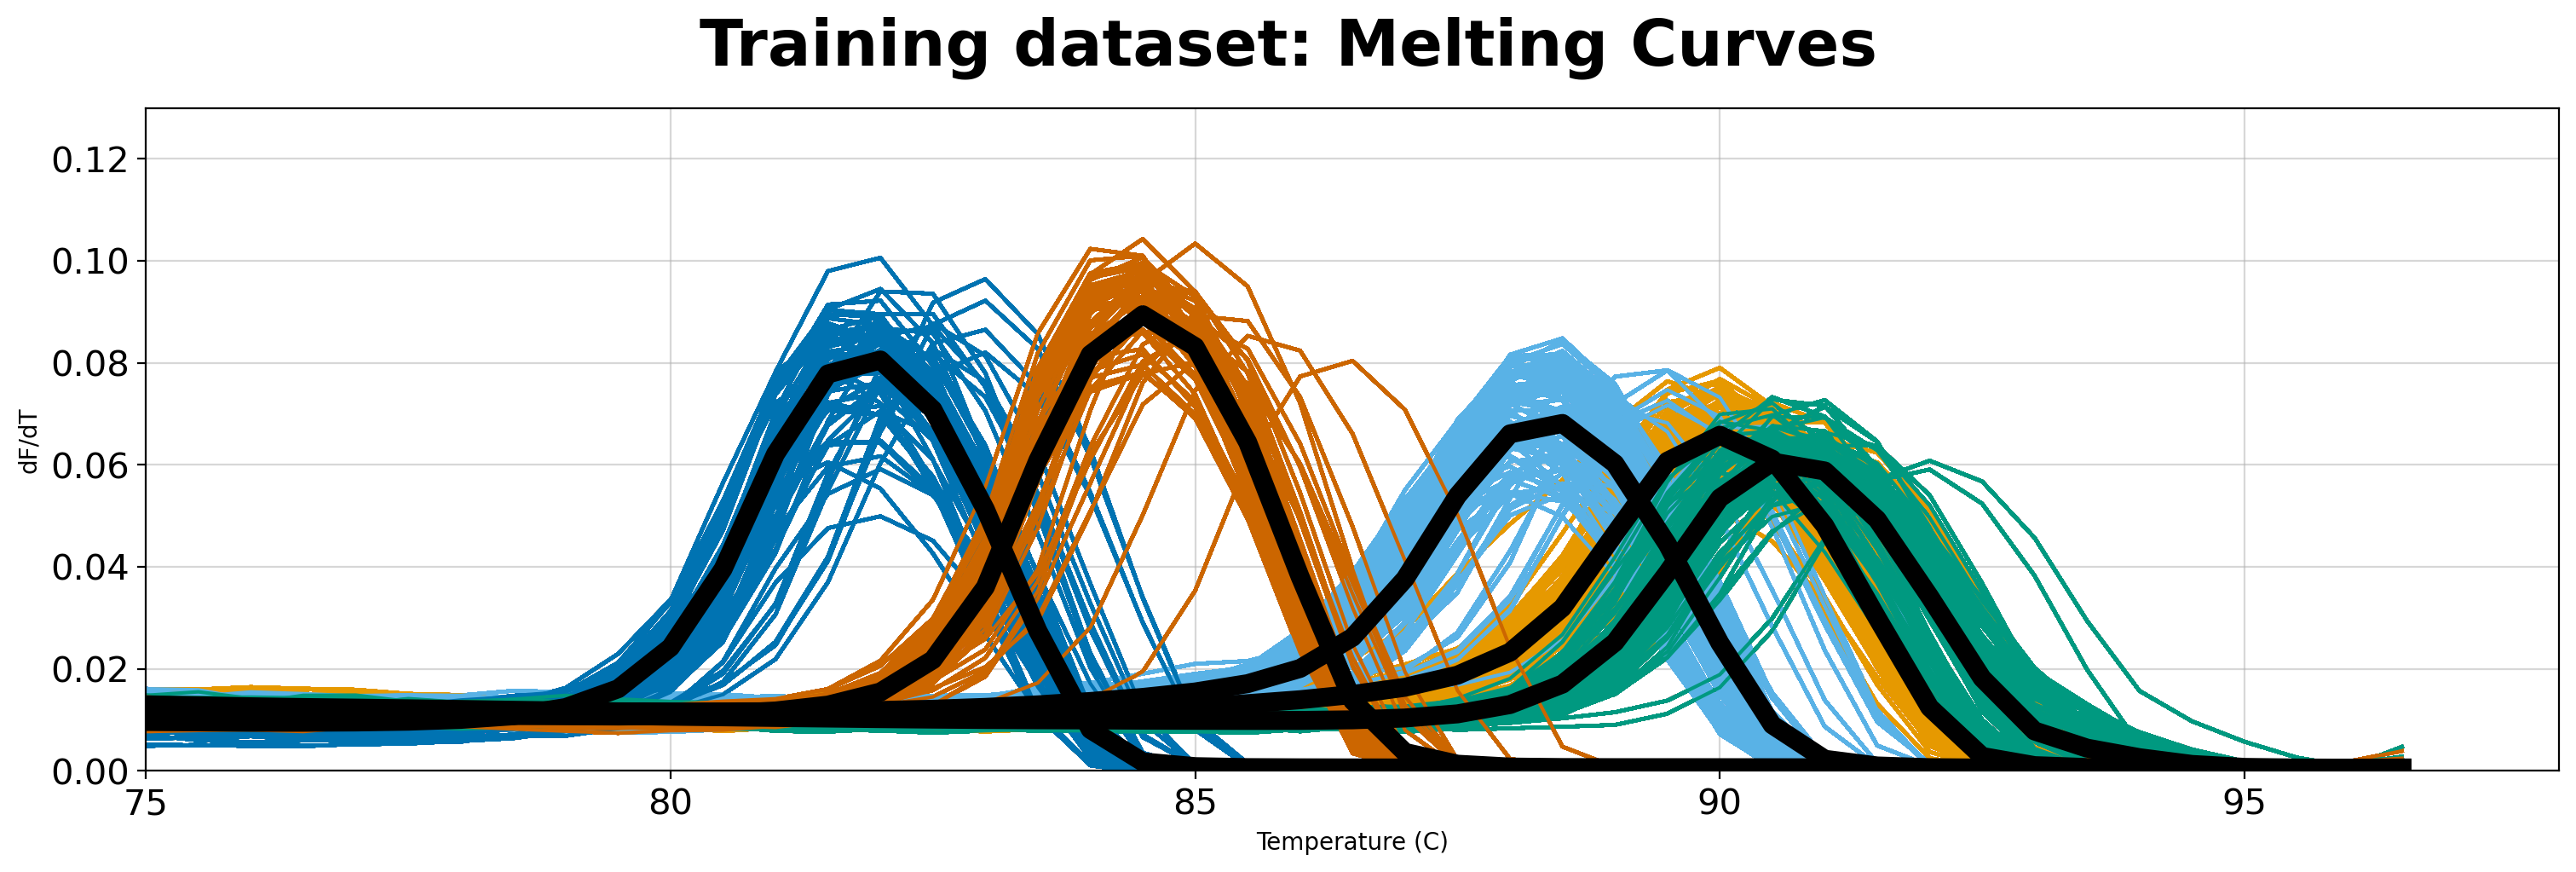

In [8]:
plotfunc.plot_training_melting_curves(df_MC_filt, NMETA)

## Melting peaks distribution
Melting peak (Tm) distribution from the dPCR instrument, showing the probability density function (PDF) for each target.

In [9]:
train_plot = df_master.loc[df_master.Conc != 'unk']

for target, df_ in train_plot.groupby('Target'):
    melt_mean = df_["MeltPeaks"].mean()
    print(f"Target: {target} --> Melting peak Tm mean: {round(melt_mean,3)}")

Target: IMP --> Melting peak Tm mean: 81.852
Target: KPC --> Melting peak Tm mean: 89.984
Target: NDM --> Melting peak Tm mean: 90.674
Target: OXA48 --> Melting peak Tm mean: 84.536
Target: VIM --> Melting peak Tm mean: 88.321


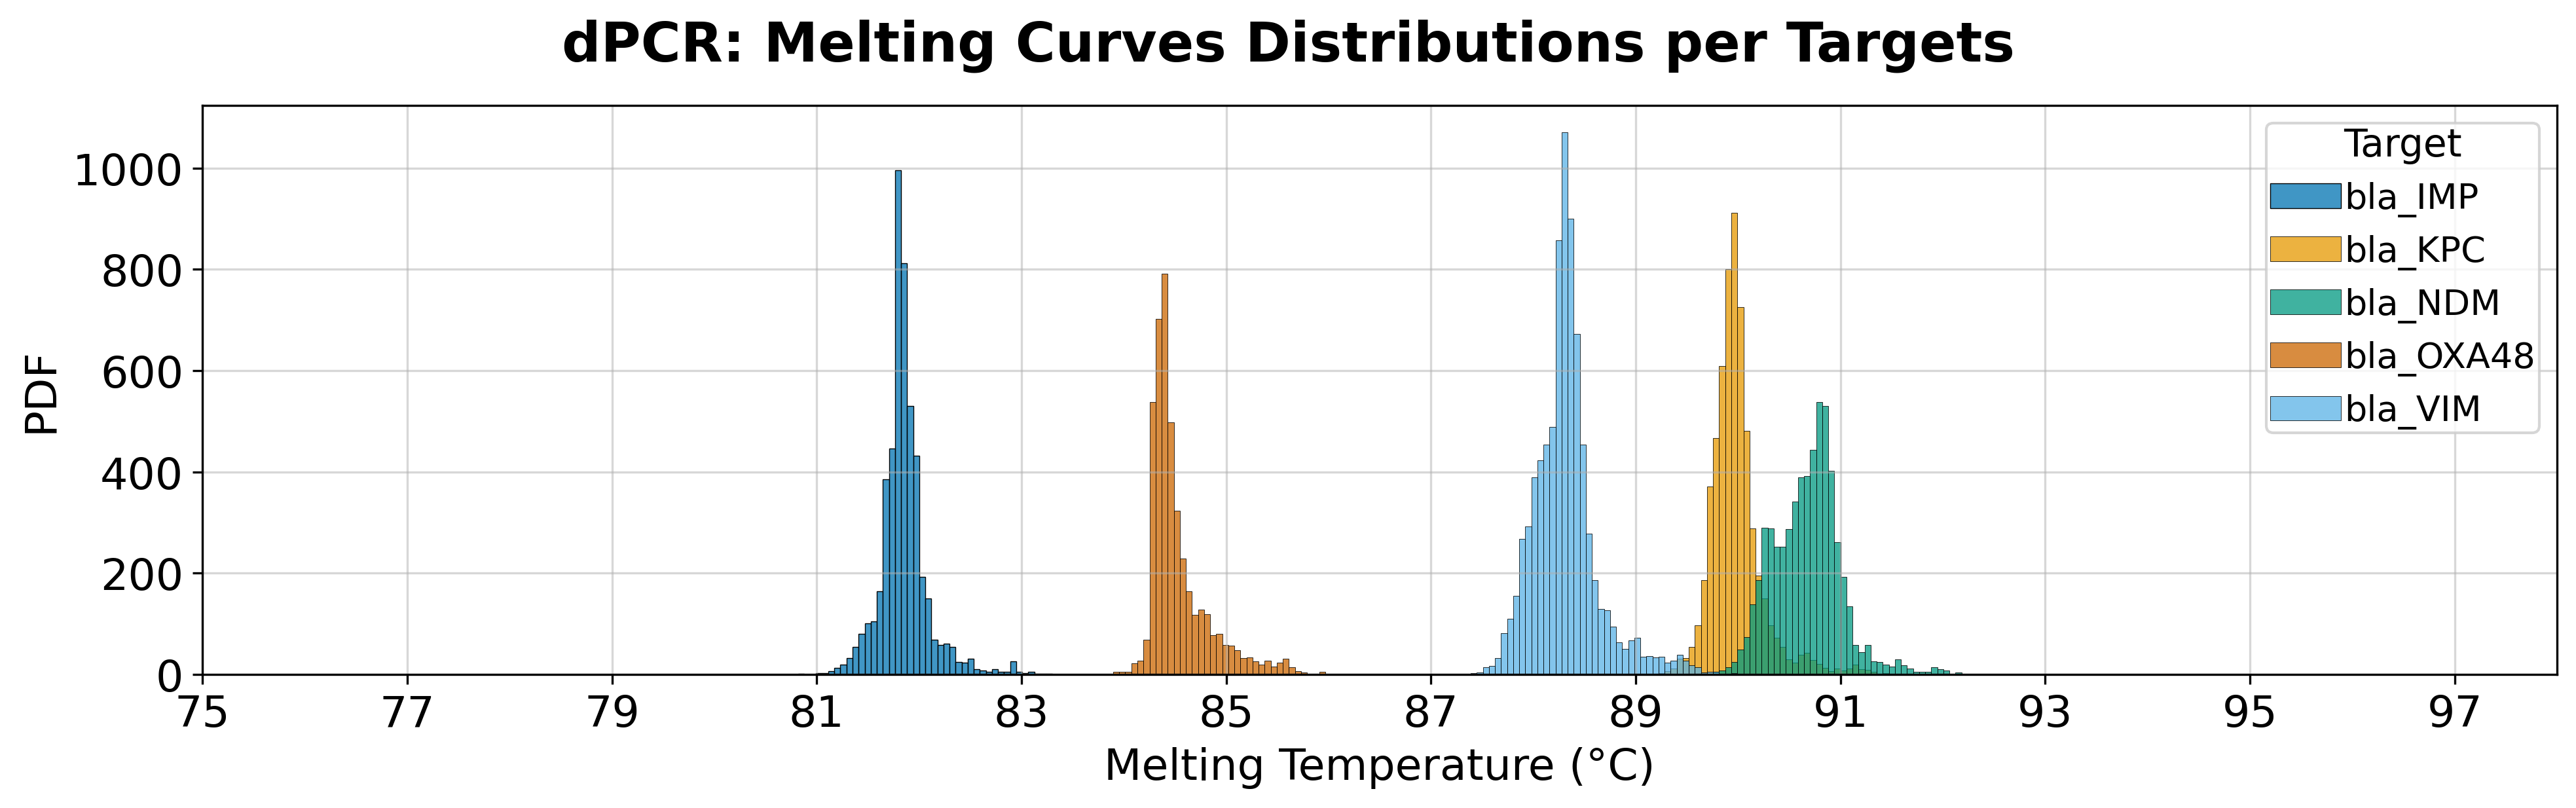

In [10]:
plotfunc.plot_melting_peaks_distribution(train_plot, NMETA)

## Digital Standard Curves
The 5-plex PCR assay was further validated in the dPCR platform with synthetic DNA templates at concentrations ranging from 10^1 to 10^5 DNA copies per panel.

Digital PCR standards have 2 region refer as Single Molecule and Bulk. In the Single Molecule region at the increase of copies/panel the Cq values stay the same, instead in the Bulk region we observe a typical real-time PCR standard curve trend.

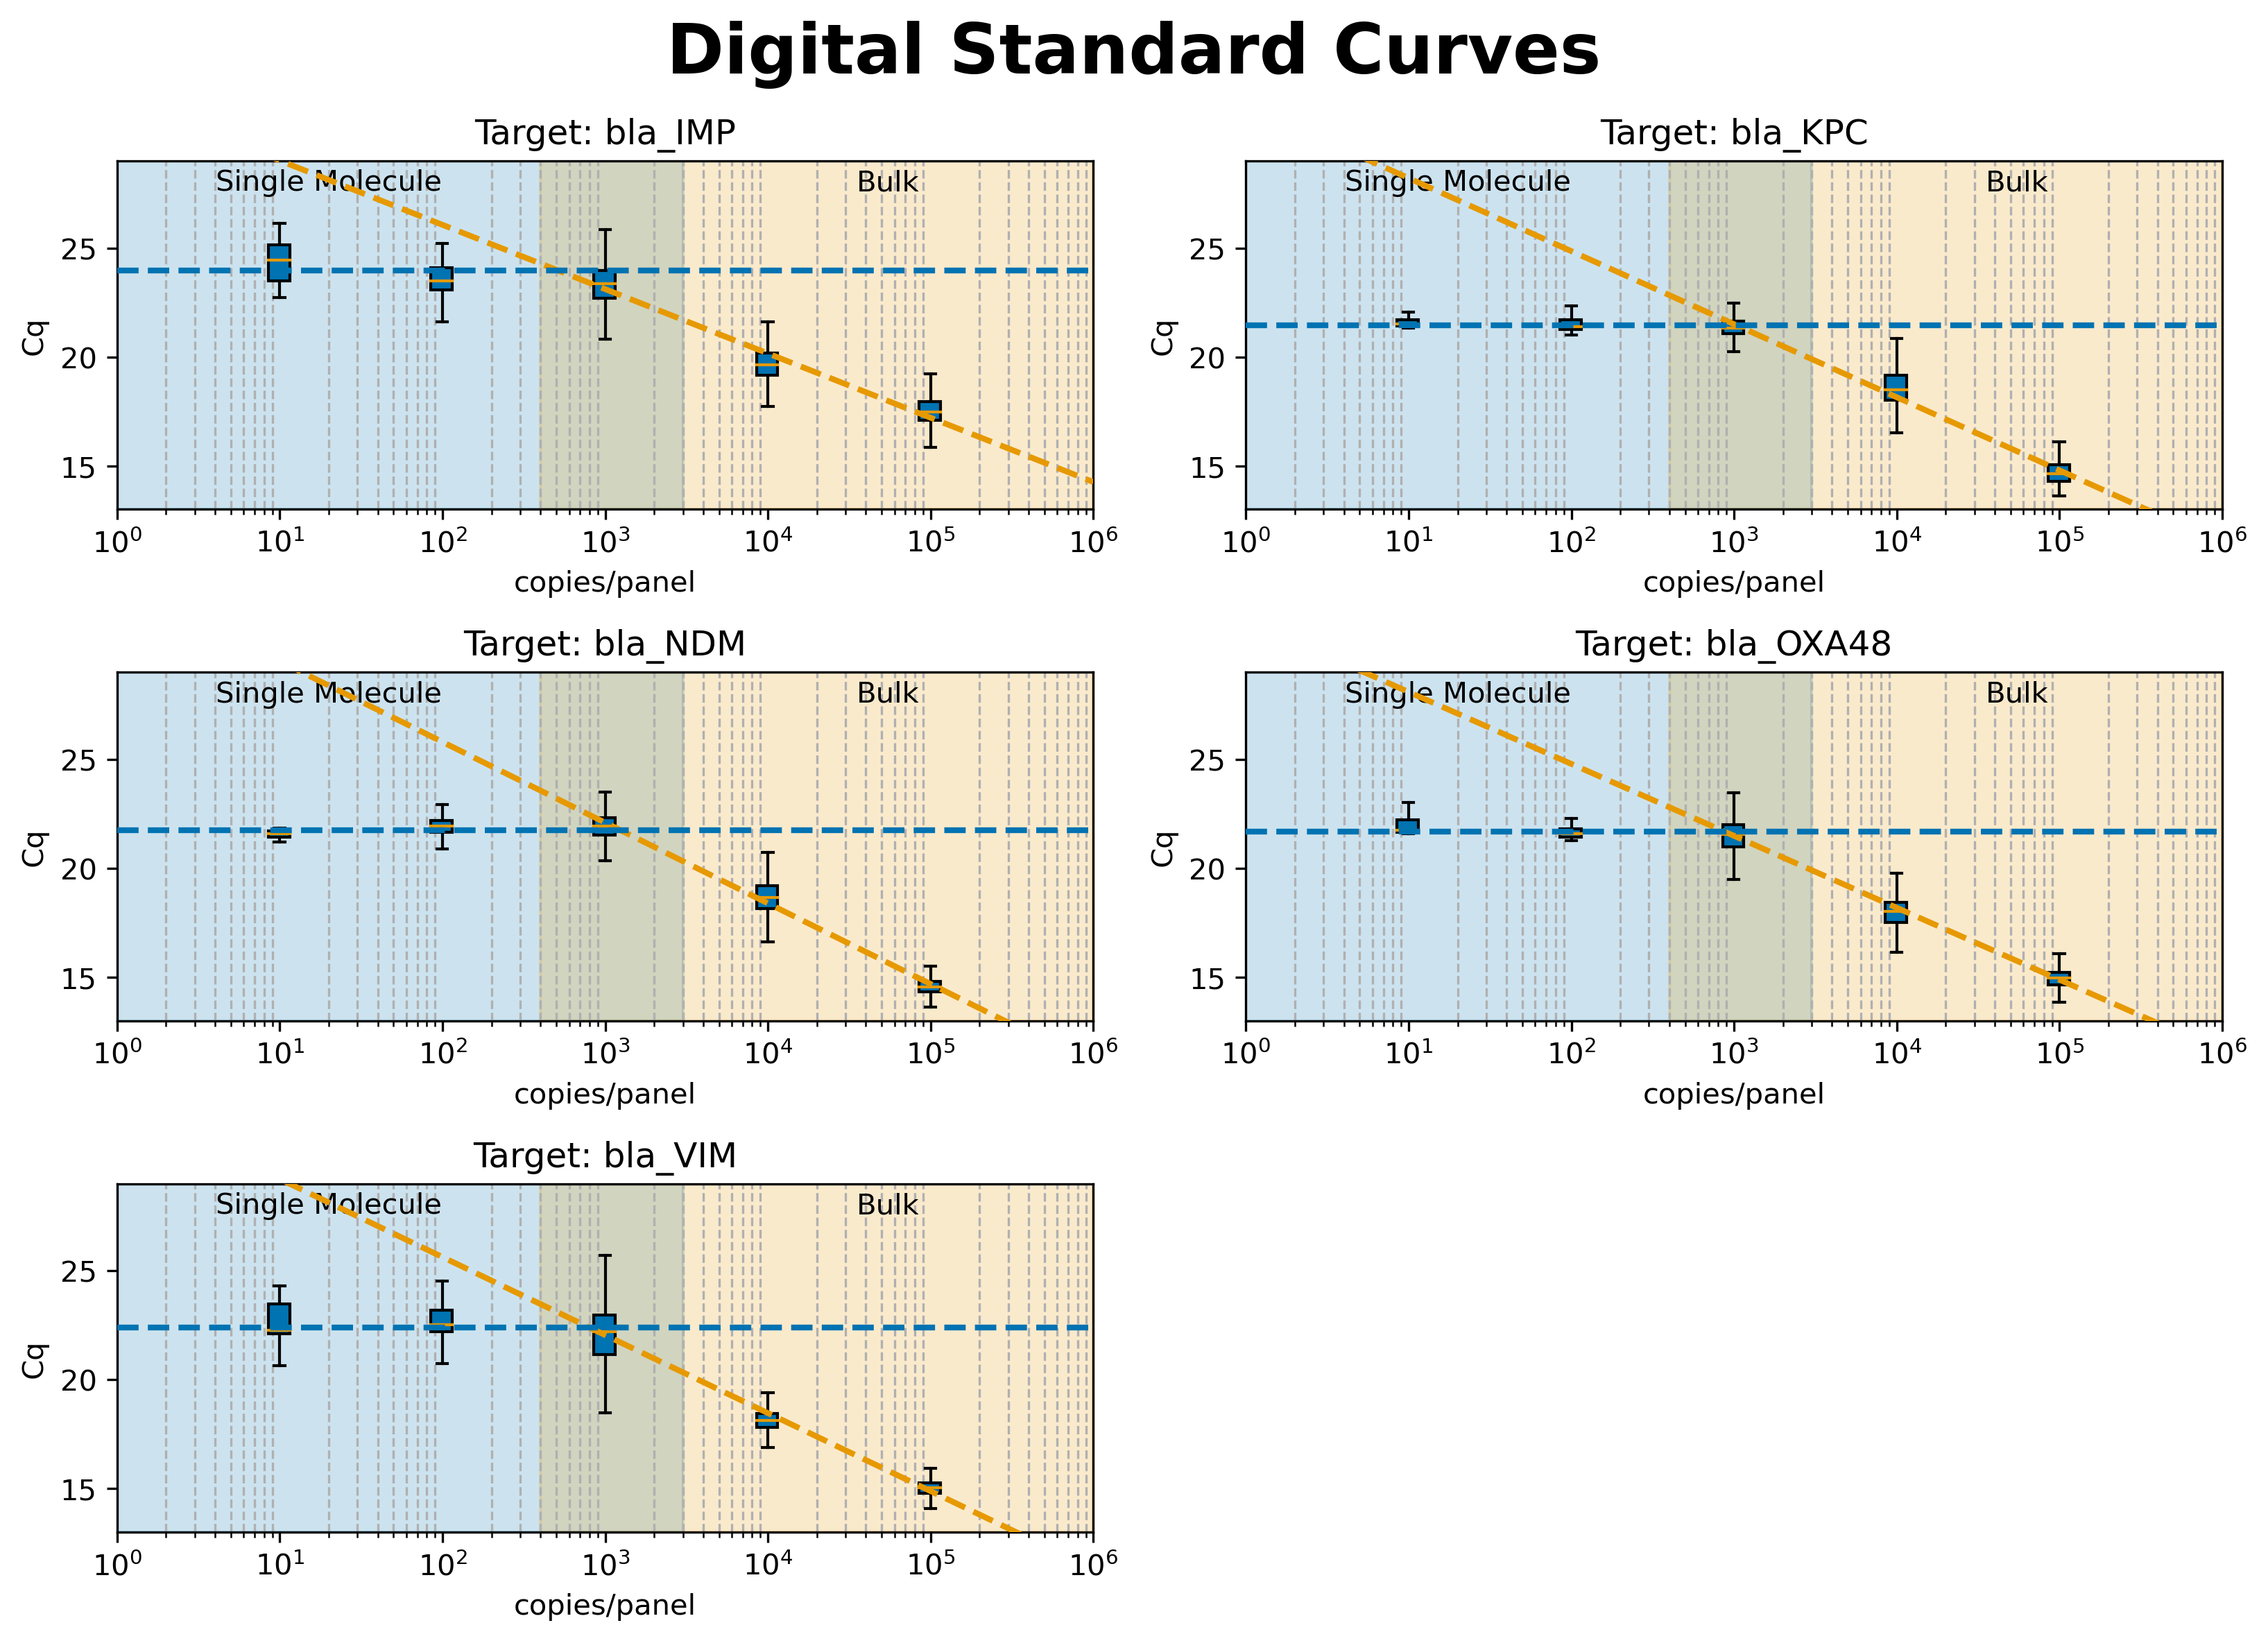

In [11]:
plotfunc.plot_training_dilution(df_training, NMETA)

# MACHINE LEARNING ALGORITHM

In [12]:
# Importing Libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix

In [13]:
df_master_dPCR = df_master.copy()
print('total clinical samples:', len(df_master_dPCR.loc[df_master_dPCR.Conc=='unk'].Target.unique()))

total clinical samples: 221


## Encoding labels and select dataset
- Encoding the levels of categorical features into numeric values.
- Defining the True labels (or Y labels)

In [14]:
X_AC = df_master_dPCR.iloc[:, NMETA+1:].values
X_MC = df_master_dPCR.loc[:, ['MeltPeaks']].values
X_FFI = X_AC[:,[-1]]

encoder_master = LabelEncoder()
encoder_master.fit(df_master_dPCR['CPE_type'])

ytrue = encoder_master.transform(df_master_dPCR['CPE_type'])

X_MC.shape, X_AC.shape, X_FFI.shape, ytrue.shape

((160041, 1), (160041, 45), (160041, 1), (160041,))

In [15]:
# This defines the test dataset indexes (samples are at unknown concentration)
test_idx = df_master_dPCR.Conc=='unk'
# This defines the training dataset indexes
train_idx = ~test_idx

# Here data are analysed separatly based on:
# AMPLIFICATION CURVES (AC)
X_AC_train, X_AC_test = X_AC[train_idx], X_AC[test_idx]
# MELTING CURVES (MC)
X_MC_train, X_MC_test = X_MC[train_idx], X_MC[test_idx]
# FINAL FLUORESCENCE INTESITY (FFI)
X_FFI_train, X_FFI_test = X_FFI[train_idx], X_FFI[test_idx]

# True label for training and testing dataset
y_train, y_test = ytrue[train_idx], ytrue[test_idx]

print('Training on:', y_train.shape[0], ' -->  Testing on:', y_test.shape[0])

Training on: 29165  -->  Testing on: 130876


## Logistic Regression and k-NN
In this cell we are training the model for Amplification Curve (AC) and Melting Curves (MC).
- The AC model is a k-nearest neighbors algorithm (k-NN)
- The MC model is a logistic regression model
- The AMCA model as it is a result of the two model concatenation follows a logistic regression model

In [16]:
########## create/train model for AC ##########
clf_AC, clf_AC_proba = mlfunc.train_ACA_model(X_AC_train, y_train, n_neighbors=20)

########## create/train model for MC ##########    
clf_MC, clf_MC_proba = mlfunc.train_MCA_model(X_MC_train, y_train, max_iter=1000)

########## create/train model for FFI ##########
clf_FFI, clf_FFI_proba = mlfunc.train_FFI_model(X_FFI_train, y_train, max_iter=1000)

########## create/train model for AMCA ##########
# concatenating all the data from ACA and MCA
X_AC_MC_train = np.concatenate((clf_MC_proba, clf_AC_proba), axis=1)
clf, clf_proba = mlfunc.train_AMCA_model(X_AC_MC_train, y_train, max_iter=1000, fit_intercept=False)
X_AC_MC_test = np.concatenate((clf_MC.predict_proba(X_MC_test), clf_AC.predict_proba(X_AC_test)), axis=1)

y_preds = clf.predict(X_AC_MC_test)
y_trues = y_test.copy()

y_preds_AC = clf_AC.predict(X_AC_test)
y_preds_MC = clf_MC.predict(X_MC_test)
y_preds_FFI = clf_FFI.predict(X_FFI_test)

idx_confidence = np.ones(len(y_preds_AC), dtype=bool)

## Confusion Matrix classification at WELL LEVEL
Here the Confusion Matrix is plotted.
It shows on the y_axis the true label and the x_label with the predicted.

Diagonal numbers refer to the correct algorithm call (from the AMCA method). Moreover, since this analysis is done at the Well level, the confusion matrix number refers to a number of wells in digital PCR (for example, IMPxIMP: 26848 amplification reactions)

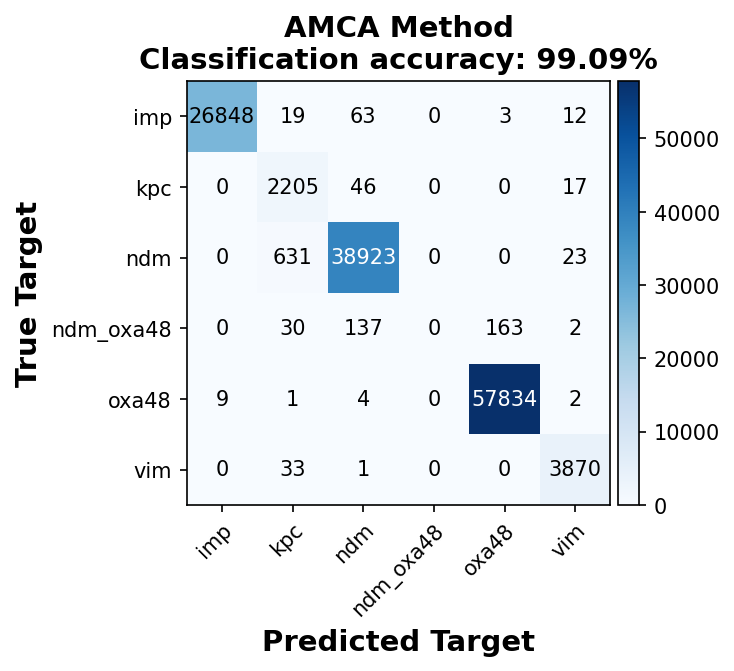

In [17]:
classes = encoder_master.classes_

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=150)

plotfunc.plot_confusion_matrix(y_trues[idx_confidence], y_preds[idx_confidence], classes, ax, normalize=False)
ax.set_title('AMCA Method\n'+ax.get_title(), fontsize=14, weight='bold')
ax.set_ylabel('True Target', fontsize=14, weight='bold')
ax.set_xlabel('Predicted Target', fontsize=14, weight='bold')

plt.tight_layout()
plt.show()

## Checking panel Results (sample level)

In [18]:
def panel_results(ypred, ypanel, encoder):
    """
    This function takes the panel counts of each individual sample and
    the prediction of the AMCA algorithm.
    It also consider the occupancy of the digital PCR panel by considering
    if the panel has been occupied for more than 5%.
    This is important to output the occupancy of the panel and the predicted 
    target form the AMCA algorithm, which will be used for sample concentration count.
    """
    
    N_targets = len(encoder.classes_)

    df_panel_counts = pd.DataFrame(columns=encoder.classes_)
    df_panel_output = pd.DataFrame(columns=['Output'])

    for id_, df_ in pd.DataFrame({'Panel_ID': ypanel, 'Prediction': ypred}).groupby('Panel_ID'):
        empty_series = pd.Series(index=range(N_targets), data=np.zeros(N_targets), dtype=int)
        
        for i, value in df_['Prediction'].value_counts().items():
            empty_series.loc[i] = value
        
        df_panel_counts.loc[id_] = empty_series.values

        # WE CLASSIFY PANEL IF THE OCCUPANCY OF IT IS MORE THAN 5%
        idx = np.where(empty_series.values>39)[0]
        df_panel_output.loc[id_] = '_'.join(encoder.classes_[idx]) if len(idx)>0 else ['Empty']

    return df_panel_counts, df_panel_output

In [19]:
panel_encoder = LabelEncoder()
ypanel = panel_encoder.fit_transform(df_master_dPCR['Channel']+'_'+df_master_dPCR['Target']+'_'+df_master_dPCR['CPE_type'])
ypanel_train, ypanel_test = ypanel[train_idx], ypanel[test_idx]

In [20]:
df_panel_counts_true, df_panel_output_true = panel_results(y_test[idx_confidence], ypanel_test[idx_confidence], encoder_master)
df_panel_counts_true.index = panel_encoder.classes_[df_panel_counts_true.index]
df_panel_output_true.index = panel_encoder.classes_[df_panel_output_true.index]

## Confusion Matrix classification at SAMPLE LEVEL
Here it can be visualised the classificaiton accuracy of the MCA or the AMCA algorithm at Sample Level.

Diagonal numbers refer to the correct algorithm call (from the AMCA method). Here each sample is classified based on the well level analysis performed in the previous cells (for example if more than 5% of the panel is occupied by a "predicted" NDM amplification curves in each well, then the sample will be calssified as NDM). 

Data output is displayed below:

In [21]:
# CHOSE THE METHOD TO RUN THE ANALYSIS

METHOD = 'AMCA' # or "MCA"

if METHOD == 'AMCA':
    df_panel_counts_pred, df_panel_output_pred = panel_results(y_preds[idx_confidence], ypanel_test[idx_confidence], encoder_master)
elif METHOD == 'MCA':
    df_panel_counts_pred, df_panel_output_pred = panel_results(y_preds_MC[idx_confidence], ypanel_test[idx_confidence], encoder_master)

df_panel_counts_pred.index = panel_encoder.classes_[df_panel_counts_pred.index]
df_panel_output_pred.index = panel_encoder.classes_[df_panel_output_pred.index]

result = df_panel_counts_pred.join(df_panel_output_pred)
result['True'] = ['_'.join(i.split('_')[2:]) for i in result.index]

result.head()

,imp,kpc,ndm,ndm_oxa48,oxa48,vim,Output,True
panel01_CPO040_imp,380,0,0,0,0,0,imp,imp
panel01_CPO050_imp,283,2,0,0,0,0,imp,imp
panel01_CPO121_ndm,0,9,701,0,0,0,ndm,ndm
panel01_CPO171_oxa48,0,0,0,0,763,0,oxa48,oxa48
panel01_CPO182_oxa48,1,0,0,0,768,0,oxa48,oxa48


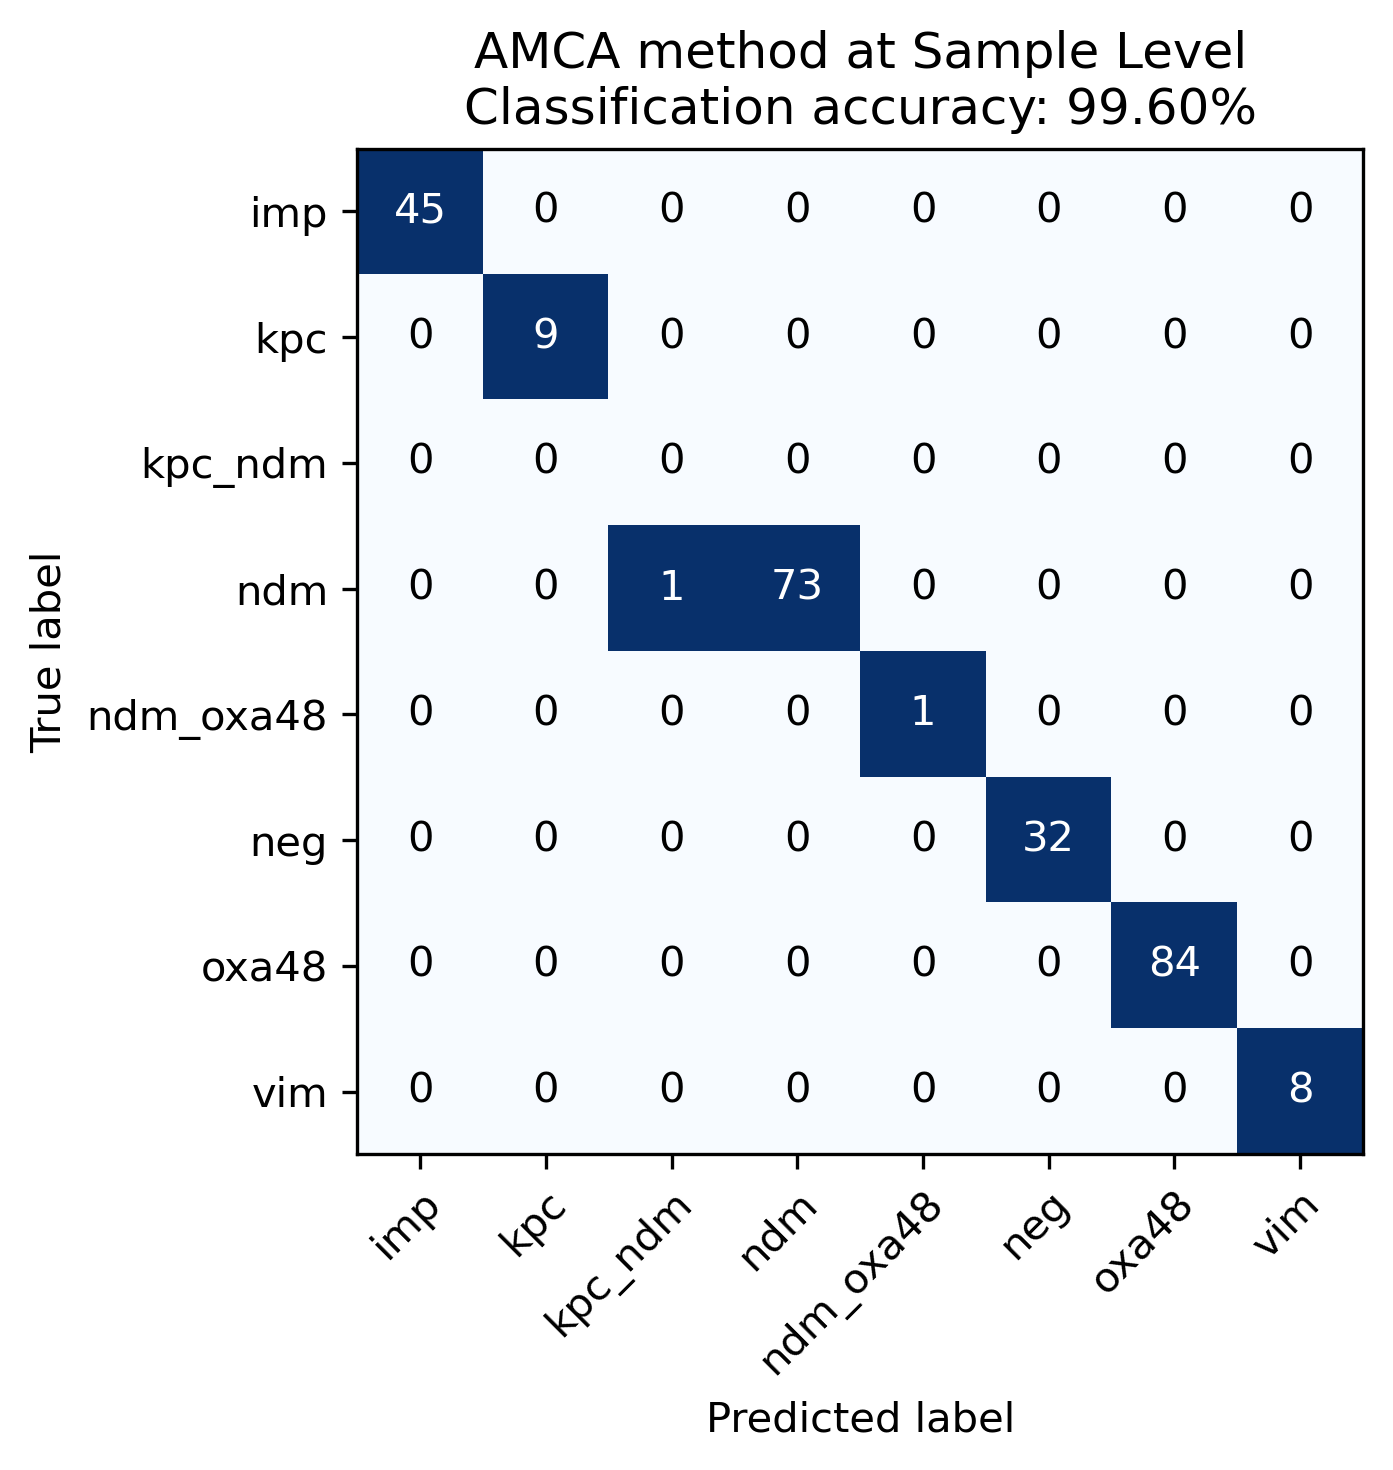

In [22]:
# PLOTTING CONFUSION MATRIX AT SAMPLE LEVEL

temp = np.append(np.unique(result[['True', 'Output']].values.reshape(-1)), 'neg')

enc = LabelEncoder()
enc.fit(temp)

classes = enc.classes_

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=300)

plotfunc.plot_custom_confusion_matrix(np.append(enc.transform(result['True'].values.reshape(-1)), 
                                         enc.transform(['neg']*32)), 
                               np.append(enc.transform(result['Output'].values.reshape(-1)), 
                                         enc.transform(['neg']*32)), 
                               classes, ax, normalize=False)

plt.tight_layout()
plt.show()